# Image Classification with Convolutional Neural Networks

In this notebook, an image classification pipeline is implemented using Convolutional Neural Networks (CNNs) with TensorFlow Keras.

## Prerequisites

Ensure you have the following libraries installed:

- NumPy
- pandas
- Matplotlib
- OpenCV (cv2)
- scikit-learn
- TensorFlow
- Keras

## Importing Required Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
from matplotlib import pyplot as plt 
%matplotlib inline 
import cv2  
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras.models import load_model

# Data Preprocessing

## Loading Data

Combining and restructuring multiple CSV files containing image data.

In [2]:
# Reading CSV files

data_1 = pd.read_csv("images-1.csv")

# Columns 0 and 1 are swapped to correct the order
data_1.iloc[:, [0, 1]] = data_1.iloc[:, [1, 0]]

# Renamed columns: "label" to "image_id", "image_name" to "Type"
data_1 = data_1.rename(columns={"label":"image_id", "image_name":"Type"})

# Columns are selected using `usecols` parameter: 'id' and 'articleType'
data_2 = pd.read_csv("images-2.csv",usecols=['id','articleType'])

# Renamed columns: "id" to "image_id", "articleType" to "Type"
data_2 = data_2.rename(columns={"id":"image_id", "articleType":"Type"})

# Columns are selected using `usecols` parameter: 'image' and 'label'
data_3 = pd.read_csv("images-3.csv",usecols=['image','label'])

# Renamed columns: "image" to "image_id", "label" to "Type"
data_3 = data_3.rename(columns={"image":"image_id", "label":"Type"})

In [3]:
# converting the 'image_id' column values to string type and appending '.jpg' extension
data_2['image_id'] = data_2['image_id'].astype(str)
data_2['image_id'] = data_2['image_id'] + '.jpg'

In [4]:
# converting the 'image_id' column values to string type and appending '.jpg' extension
data_3['image_id'] = data_3['image_id'].astype(str)
data_3['image_id'] = data_3['image_id'] + '.jpg'

In [5]:
# removing the last character from the 'Type' column values
data_1['Type'] = data_1['Type'].str[:-1]

In [7]:
# concatenates the three preprocessed DataFrames (`data_1`, `data_2`, `data_3`) into a single DataFrame (`combined_data`)
combined_data = pd.concat([data_1, data_2, data_3])

## Data Analysis

To helps ensure the quality of data going into the model, leading to more reliable results.

In [8]:
# count the occurrences of each type in the 'Type' column of the `combined_data` DataFrame
type_counts = combined_data['Type'].value_counts()

# Convert to DataFrame and reset index
type_counts_df = type_counts.reset_index()

# Rename columns
type_counts_df.columns = ['Type', 'Count']

print(type_counts_df)

                    Type  Count
0                Tshirts   7070
1                Watches   3542
2                 Shirts   3217
3           Casual Shoes   2846
4             Sunglasses   2073
..                   ...    ...
168  Body Wash and Scrub      1
169    Mens Grooming Kit      1
170       Cushion Covers      1
171           Shoe Laces      1
172                 Ipad      1

[173 rows x 2 columns]


## Data Refinement

To dicrease number of redundant and not wanted labels

In [8]:
replacements = {'Flip_Flops' :'Flip Flops','Tshirts':'T-Shirts','T-Shirt':'T-Shirts' ,'Casual Shoes':'Shoes','Formal Shoes':'Shoes','Sports Shoes':'Shoes','Heels':'Shoes','Flats':'Shoes','Lounge Tshirts' : 'T-Shirts','Lounge Shorts':'Shorts',
                'Blazers':'Blazer','Blouses':'Blouse','Sports Sandals':'Sandals','Face Moisturisers':'Cosmetics','Face Scrub and Exfoliator':'Cosmetics','Face Serum and Gel':'Cosmetics','Face Wash and Cleanser':'Cosmetics',
                'Eye Cream':'Cosmetics','Kajal and Eyeliner':'Cosmetics','Fragrance Gift Set':'Cosmetics','Perfume and Body Mist':'Cosmetics','Lip Care':'Cosmetics','Lip Gloss':'Cosmetics','Lip Liner':'Cosmetics','Foundation and Primer':'Cosmetics',
                'Highlighter and Blush':'Cosmetics','Compact':'Cosmetics','Lip Plumper':'Cosmetics','Lipstick':'Cosmetics','Makeup Remover':'Cosmetics','Mascara':'Cosmetics','Mask and Peel':'Cosmetics','Mens Grooming Kit':'Cosmetics','Nail Essentials':'Cosmetics',
                'Nail Polish':'Cosmetics','Sunscreen':'Cosmetics','Toner':'Cosmetics','Deodorant':'Cosmetics','Eyeshadow':'Cosmetics','Hair Colour':'Cosmetics','Concealer':'Cosmetics','Body Lotion':'Cosmetics','Beauty Accessory': 'Cosmetics','Hair Accessories': 'Accessories',
                'Hair Accessory':'Accessories','Body Wash and Scrub':'Cosmetics','Jewellery Set':'Jewellery','Earrings':'Jewellery','Pendant':'Jewellery','Bangle':'Jewellery','Booties':'Socks','Accessory Gift Set':'Accessories','Baby Dolls':'Loungewear and Nightwear',
                'Bath Robe':'Loungewear and Nightwear','Night suits':'Loungewear and Nightwear','Suits':'Loungewear and Nightwear','Nightdress':'Loungewear and Nightwear','Robe':'Loungewear and Nightwear','Tops':'Topwear','Kurtas':'Topwear','Waistcoat':'Topwear','Blazers':'Topwear',
                'Shrug':'Topwear','Dupatta':'Topwear','Tunics':'Topwear','Kurtis':'Topwear','Suspenders':'Topwear','Lehenga Choli':'Topwear','Rompers':'Topwear','Rain Jacket':'Jacket','Necklace and Chains':'Jewellery','Ring':'Jewellery','Bracelet':'Jewellery','Backpacks':'Bags',
                'Clutches':'Bags','Duffel Bag':'Bags','Handbags':'Bags','Laptop Bag':'Bags', 'Messenger Bag':'Bags', 'Mobile Pouch':'Bags','Rucksacks':'Bags','Tablet Sleeve':'Bags','Travel Accessory':'Bags','Trolley Bag':'Bags', 'Waist Pouch':'Bags', 'Boxers':'Innerwear','Bra':'Innerwear',
                'Briefs':'Innerwear','Camisoles':'Innerwear','Innerwear Vests':'Innerwear','Shapewear':'Innerwear','Trunk':'Innerwear','Nehru Jackets':'Jacket','Footballs':'Ball','Basketballs':'Ball','Scarves':'Scarf','Mufflers':'Scarf','Capris':'Pants','Churidar':'Pants','Jeans':'Pants',
                'Jeggings':'Pants','Leggings':'Pants','Patiala':'Pants','Rain Trousers':'Pants','Salwar':'Pants','Lounge Pants':'Pants','Salwar and Dupatta':'Pants','Skirts':'Bottomwear','Stockings':'Bottomwear','Track Pants':'Pants','Trousers':'Pants','Tights':'Pants','Tracksuits':'Sport',
                'Wristbands':'Sport','Swimwear':'Sport','Sarees':'Dress','Jumpsuit':'Dress','Stoles':'Scarf','Water Bottle':'Accessories','Headband':'Sport','Caps':'Headwear','Hat':'Headwear','Hats':'Headwear','Shoe Laces':'Shoe Accessories','Jackets':'Jacket','Sneakers':'Shoes',
                'Boots':'Shoes','Makeup':'Cosmetics','Polo':'Shirts','Handbag':'Bags','Skip':'Dress','Top':'Innerwear','Blazer':'Jacket','Pumps':'Shoes','Clutch':'Bags','Outwear':'Jacket','Shirt':'Shirts','Sweatshirts':'Topwear','Dresses':'Dress','Undershirt':'Innerwear'}

# Function to refine types based on mapping
def refine_types(row):
    type_value = row['Type'].strip()  # Strip leading and trailing spaces
    if type_value in replacements:
        return replacements[type_value]
    else:
        return type_value  

combined_data['Type'] = combined_data.apply(refine_types, axis=1)

In [9]:
conditions = [
    combined_data['Type'] == 'Free Gifts',
    combined_data['Type'] == 'Cushion Covers',
    combined_data['Type'] == 'Ipad',
    combined_data['Type'] == 'Clothing Set',
    combined_data['Type'] == 'Key chain',
    combined_data['Type'] == 'Ties and Cufflinks',
    combined_data['Type'] == 'Umbrellas',
    combined_data['Type'] == 'Ball',
    combined_data['Type'] == 'Gloves',
    combined_data['Type'] == 'Shoe Accessories', 
    combined_data['Type'] == 'Not sure',
    combined_data['Type'] == 'Other'
]

combined_mask = pd.concat(conditions, axis=1).any(axis=1)

# Filter out rows based on the combined mask and retrieve the image_ids of the dropped rows
dropped_image_ids = combined_data.loc[combined_mask, 'image_id']

# Drop rows based on the combined mask
combined_data = combined_data[~combined_mask]

Showing results after Data refinement

In [10]:
type_counts = combined_data['Type'].value_counts()

# Convert to DataFrame and reset index
type_counts_df = type_counts.reset_index()

# Rename columns
type_counts_df.columns = ['Type', 'Count']

print(type_counts_df)

                        Type  Count
0                      Shoes  11676
1                   T-Shirts   9084
2                       Bags   5084
3                    Topwear   4555
4                     Shirts   3715
5                      Pants   3696
6                    Watches   3542
7                  Cosmetics   2712
8                      Dress   2139
9                  Jewellery   2080
10                Sunglasses   2073
11                 Innerwear   1969
12                   Sandals   1964
13                    Shorts   1889
14                     Belts   1813
15                    Jacket   1702
16                  Headwear   1457
17                Flip Flops   1454
18                     Scarf   1247
19                  Sweaters   1208
20                Bottomwear   1160
21               Accessories   1123
22                    Blouse   1023
23                   Wallets    936
24                Longsleeve    699
25                     Socks    698
26  Loungewear and Nightwear

## Image Loading 

Defining a function `load_images_from_folder` to load images from a specified folder and retrieve their names.

In [12]:
# TEST TO UPLOAD IMAGES WITH THEIR NAMES
def load_images_from_folder(folder_path):
   
    files = os.listdir(folder_path)

    # Filter out only image files
    image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp'))]
    
    # List to store loaded images
    images = []
    image_names = []  # List to store image names
    
    # Loop through each image file and load it
    for image_name in image_files:
        # Construct the full path to the image
        image_path = os.path.join(folder_path, image_name)
        
        # Read the image from the file path
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        # Check if the image was loaded successfully
        if image_bgr is not None:
            # Convert BGR to RGB
            image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
            
            images.append(image_rgb)
            image_names.append(image_name) 
            
        else:
            print(f"Error: Unable to load image from '{image_path}'.")
    
    return images, image_names  


folder_path = "images" 
loaded_images, image_names = load_images_from_folder(folder_path)
print(f"Number of images loaded: {len(loaded_images)}")

Number of images loaded: 71235


## Resizing 

### Resize Images to 100x100 pixels

Resize a list of images to a fixed dimension of 100x100 pixels using OpenCV.

In [13]:
# Resize all images to 100x100 pixels
loaded_images = [cv2.resize(image, (100, 100)) for image in loaded_images]

In [14]:
# Define a dictionary to store image names as keys and loaded images as values
image_dict = {}
# Iterate through the loaded images and names and populate the dictionary
for image, name in zip(loaded_images, image_names):
    image_dict[name] = image

In [15]:
# Convert the dictionary to a DataFrame
df_image = pd.DataFrame(list(image_dict.items()), columns=['image_id', 'image'])

In [16]:
df_image.head(2)

,image_id,image
0,00003aeb-ace5-43bf-9a0c-dc31a03e9cd2.jpg,"[[[105, 21, 11], [107, 23, 13], [109, 25, 15],..."
1,00070a23-9faf-4682-8243-59f307880f4b.jpg,"[[[164, 174, 150], [163, 171, 147], [172, 177,..."


In [17]:
# Merge the DataFrames
data = pd.merge(combined_data, df_image, on='image_id', how='inner')

In [18]:
data.head()

,image_id,Type,image
0,108980253.jpg,Shorts,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,Farfetch_002_Bottom_Shorts_P_209.jpg,Shorts,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,62643919.jpg,Shorts,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,197279026.jpg,Shorts,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,214699402.jpg,Shorts,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [19]:
print('All categories : \n ', data['Type'].unique())

All categories : 
  ['Shorts' 'Shoes' 'Scarf' 'Headwear' 'Cosmetics' 'T-Shirts' 'Belts' 'Bags'
 'Sweaters' 'Jewellery' 'Watches' 'Blouse' 'Flip Flops' 'Jacket' 'Sandals'
 'Bottomwear' 'Dress' 'Sunglasses' 'Accessories' 'Pants' 'Shirts' 'Socks'
 'Topwear' 'Innerwear' 'Loungewear and Nightwear' 'Wallets' 'Kurta Sets'
 'Sport' 'Ties' 'Cufflinks' 'Skirt' 'Body' 'Longsleeve' 'Hoodie']


In [20]:
n_classes = data['Type'].nunique()
print('Total number of unique categories:', n_classes)

Total number of unique categories: 34


In [21]:
# Select specific columns and convert to NumPy array
X = data[['image_id','image']].to_numpy()

## Encoding

Encoding categorical labels

In [23]:
# Initialize the LabelEncoder
encoder = LabelEncoder()

# Fit and transform the categorical labels to numerical values
Targets = encoder.fit_transform(data['Type'].to_numpy())
Targets
Targets.shape

(71904,)

In [24]:
# Convert target labels to one-hot encoded format with 'n_classes' categories
Y = to_categorical(Targets, num_classes = n_classes)
Y[0:3]
Y.shape

(71904, 34)

## Data Splitting

In [25]:
# Segregation of a test set for testing on the trained model
X_test = X[14126:]
Y_test = Y[14126:]

# Separation of a validation set from the remaining training set (required for validation while training)
X_train, X_val, Y_train, Y_val = train_test_split(X[:14126], Y[:14126], test_size=0.2, random_state=13)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(11300, 2)
(57778, 2)
(2826, 2)


### Error Handling 

Double checking of X_train, X_test, X_val shapes

In [27]:
img_rows = 100
img_cols = 100

# Extract the image data
X_train_images = np.array([image for _, image in X_train])
X_test_images = np.array([image for _, image in X_test])
X_val_images = np.array([image for _, image in X_val])

# Check the total number of elements
total_elements_train = np.prod(X_train_images.shape)
required_elements_train = X_train_images.shape[0] * img_rows * img_cols * 3

total_elements_test = np.prod(X_test_images.shape)
required_elements_test = X_test_images.shape[0] * img_rows * img_cols * 3

total_elements_val = np.prod(X_val_images.shape)
required_elements_val = X_val_images.shape[0] * img_rows * img_cols * 3

# Perform reshape if the sizes match
if total_elements_train == required_elements_train:
    X_train_images = X_train_images.reshape(X_train_images.shape[0], img_rows, img_cols, 3)
else:
    print("Error: Mismatch in total number of elements for X_train")

if total_elements_test == required_elements_test:
    X_test_images = X_test_images.reshape(X_test_images.shape[0], img_rows, img_cols, 3)
else:
    print("Error: Mismatch in total number of elements for X_test")

if total_elements_val == required_elements_val:
    X_val_images = X_val_images.reshape(X_val_images.shape[0], img_rows, img_cols, 3)
else:
    print("Error: Mismatch in total number of elements for X_val")

# Check the shape of X_val_images
print("X_val_images shape:", X_val_images.shape)

X_val_images shape: (2826, 100, 100, 3)


In [28]:
X_test_images.shape

(57778, 100, 100, 3)

In [29]:
X_train_images.shape

(11300, 100, 100, 3)

In [30]:
# img_rows, img_cols = 100, 100
input_shape = (img_rows, img_cols, 3)

# Convolutional Neural Network

## Architecture

Defining a Convolutional Neural Network (CNN) architecture using the Keras Sequential API. <br>
The CNN consists of multiple convolutional layers followed by batch normalization, max pooling, and dropout layers. <br>
It ends with fully connected layers for classification.

In [31]:
# Create a sequential model
model = Sequential()

# First convolutional layer
model.add(Conv2D(filters = 16, kernel_size = (5, 5), activation='relu',
                 input_shape = input_shape))

# Batch normalization for internal covariate shift handling
model.add(BatchNormalization())

# Second convolutional layer
model.add(Conv2D(filters = 32, kernel_size = (5, 5), activation='relu'))

# Batch normalization for internal covariate shift handling
model.add(BatchNormalization())

# Max pooling layer for downsampling
model.add(MaxPool2D(strides=(2,2)))

# Dropout layer for regularization to prevent overfitting
model.add(Dropout(0.25))

# Third convolutional layer
model.add(Conv2D(filters = 64, kernel_size = (5, 5), activation='relu'))

# Batch normalization for internal covariate shift handling
model.add(BatchNormalization())

# Forth convolutional layer
model.add(Conv2D(filters = 128, kernel_size = (5, 5), activation='relu'))

# Batch normalization for internal covariate shift handling
model.add(BatchNormalization())

# Max pooling layer for downsampling
model.add(MaxPool2D(strides=(2,2)))

# Dropout layer for regularization to prevent overfitting
model.add(Dropout(0.25))

# Flatten the data for feeding into dense layers
model.add(Flatten())

# First fully-connected (dense) layer
model.add(Dense(512, activation='relu'))

# Dropout layer for regularization to prevent overfitting
model.add(Dropout(0.25))

# Second fully-connected (dense) layer
model.add(Dense(1024, activation='relu'))

# Dropout layer for regularization to prevent overfitting
model.add(Dropout(0.4))

# Output layer with softmax activation for multi-class classification
model.add(Dense(n_classes, activation='softmax'))

# Define the learning rate for the optimizer
learning_rate = 0.0001

# Compile the model with categorical crossentropy loss, Adam optimizer, and accuracy metrics
model.compile(loss = categorical_crossentropy,
              optimizer = Adam(learning_rate),
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

c:\Users\faisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 92, 92, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 38, 38, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 38, 38, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    23,659,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 34)             │        34,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,490,370 (93.42 MB)

 Trainable params: 24,489,890 (93.42 MB)

 Non-trainable params: 480 (1.88 KB)

In [32]:
# Save the model during training
save_at = "Model-Resizing.keras" 
save_best = ModelCheckpoint(save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

## Model Execution

In [33]:
# Train the model
history = model.fit( X_train_images, Y_train, 
                    epochs = 20, batch_size = 100, 
                    callbacks=[save_best], verbose=1, 
                    validation_data = (X_val_images, Y_val))

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.3736 - loss: 2.5468 - val_accuracy: 0.4264 - val_loss: 2.3861
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.6288 - loss: 1.2063 - val_accuracy: 0.6621 - val_loss: 1.1424
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.6985 - loss: 0.9393 - val_accuracy: 0.4653 - val_loss: 2.3421
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.7421 - loss: 0.8001 - val_accuracy: 0.6582 - val_loss: 1.1985
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.7847 - loss: 0.6518 - val_accuracy: 0.6281 - val_loss: 1.4986
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.8033 - loss: 0.5913 - val_accuracy: 0.7838 - val_loss: 0.7259
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.8235 - loss: 0.5138 - val_accuracy: 0.7781 - val_loss: 0.8291
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.8499 - loss: 0.4402 - val_accu

## Model Evaluation

Ploting of accuracy aganist value accuracy

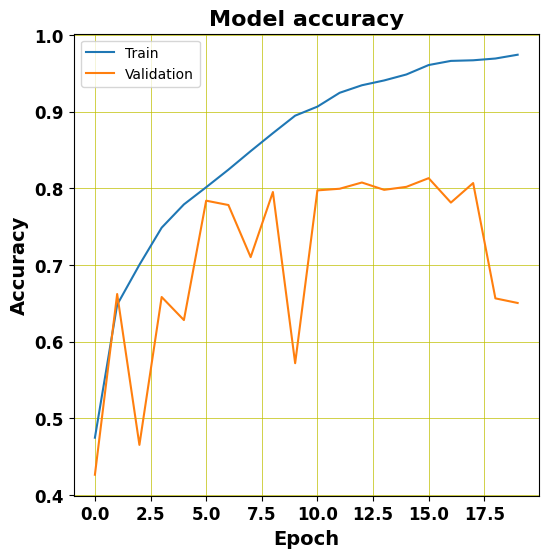

In [34]:
# Plot training & validation accuracy values
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy', weight='bold', fontsize=16)
plt.ylabel('Accuracy',weight='bold', fontsize=14)
plt.xlabel('Epoch', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

### Classification metrics 

Evaluating the model's performance on a validation dataset using three main steps: <br> 
1. Getting predictions
2. Converting predictions to class labels
3. Calculating evaluation metrics.

In [35]:
# Step 1: Get predictions
y_pred_probs = model.predict(X_val_images)  # Predictions (probabilities) on validation data

# Step 2: Convert predictions to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(Y_val, axis=1)

# Step 3: Calculate metrics
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step
Precision: 0.7416741992591599
Recall: 0.6503892427459307
F1-Score: 0.6502664624433696


## ROC Curve Analysis

Plotting ROC (Receiver Operating Characteristic) curves for each class in a multi-class classification problem. <br>

c:\Users\faisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\faisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\faisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\faisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\faisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1146: Undefined

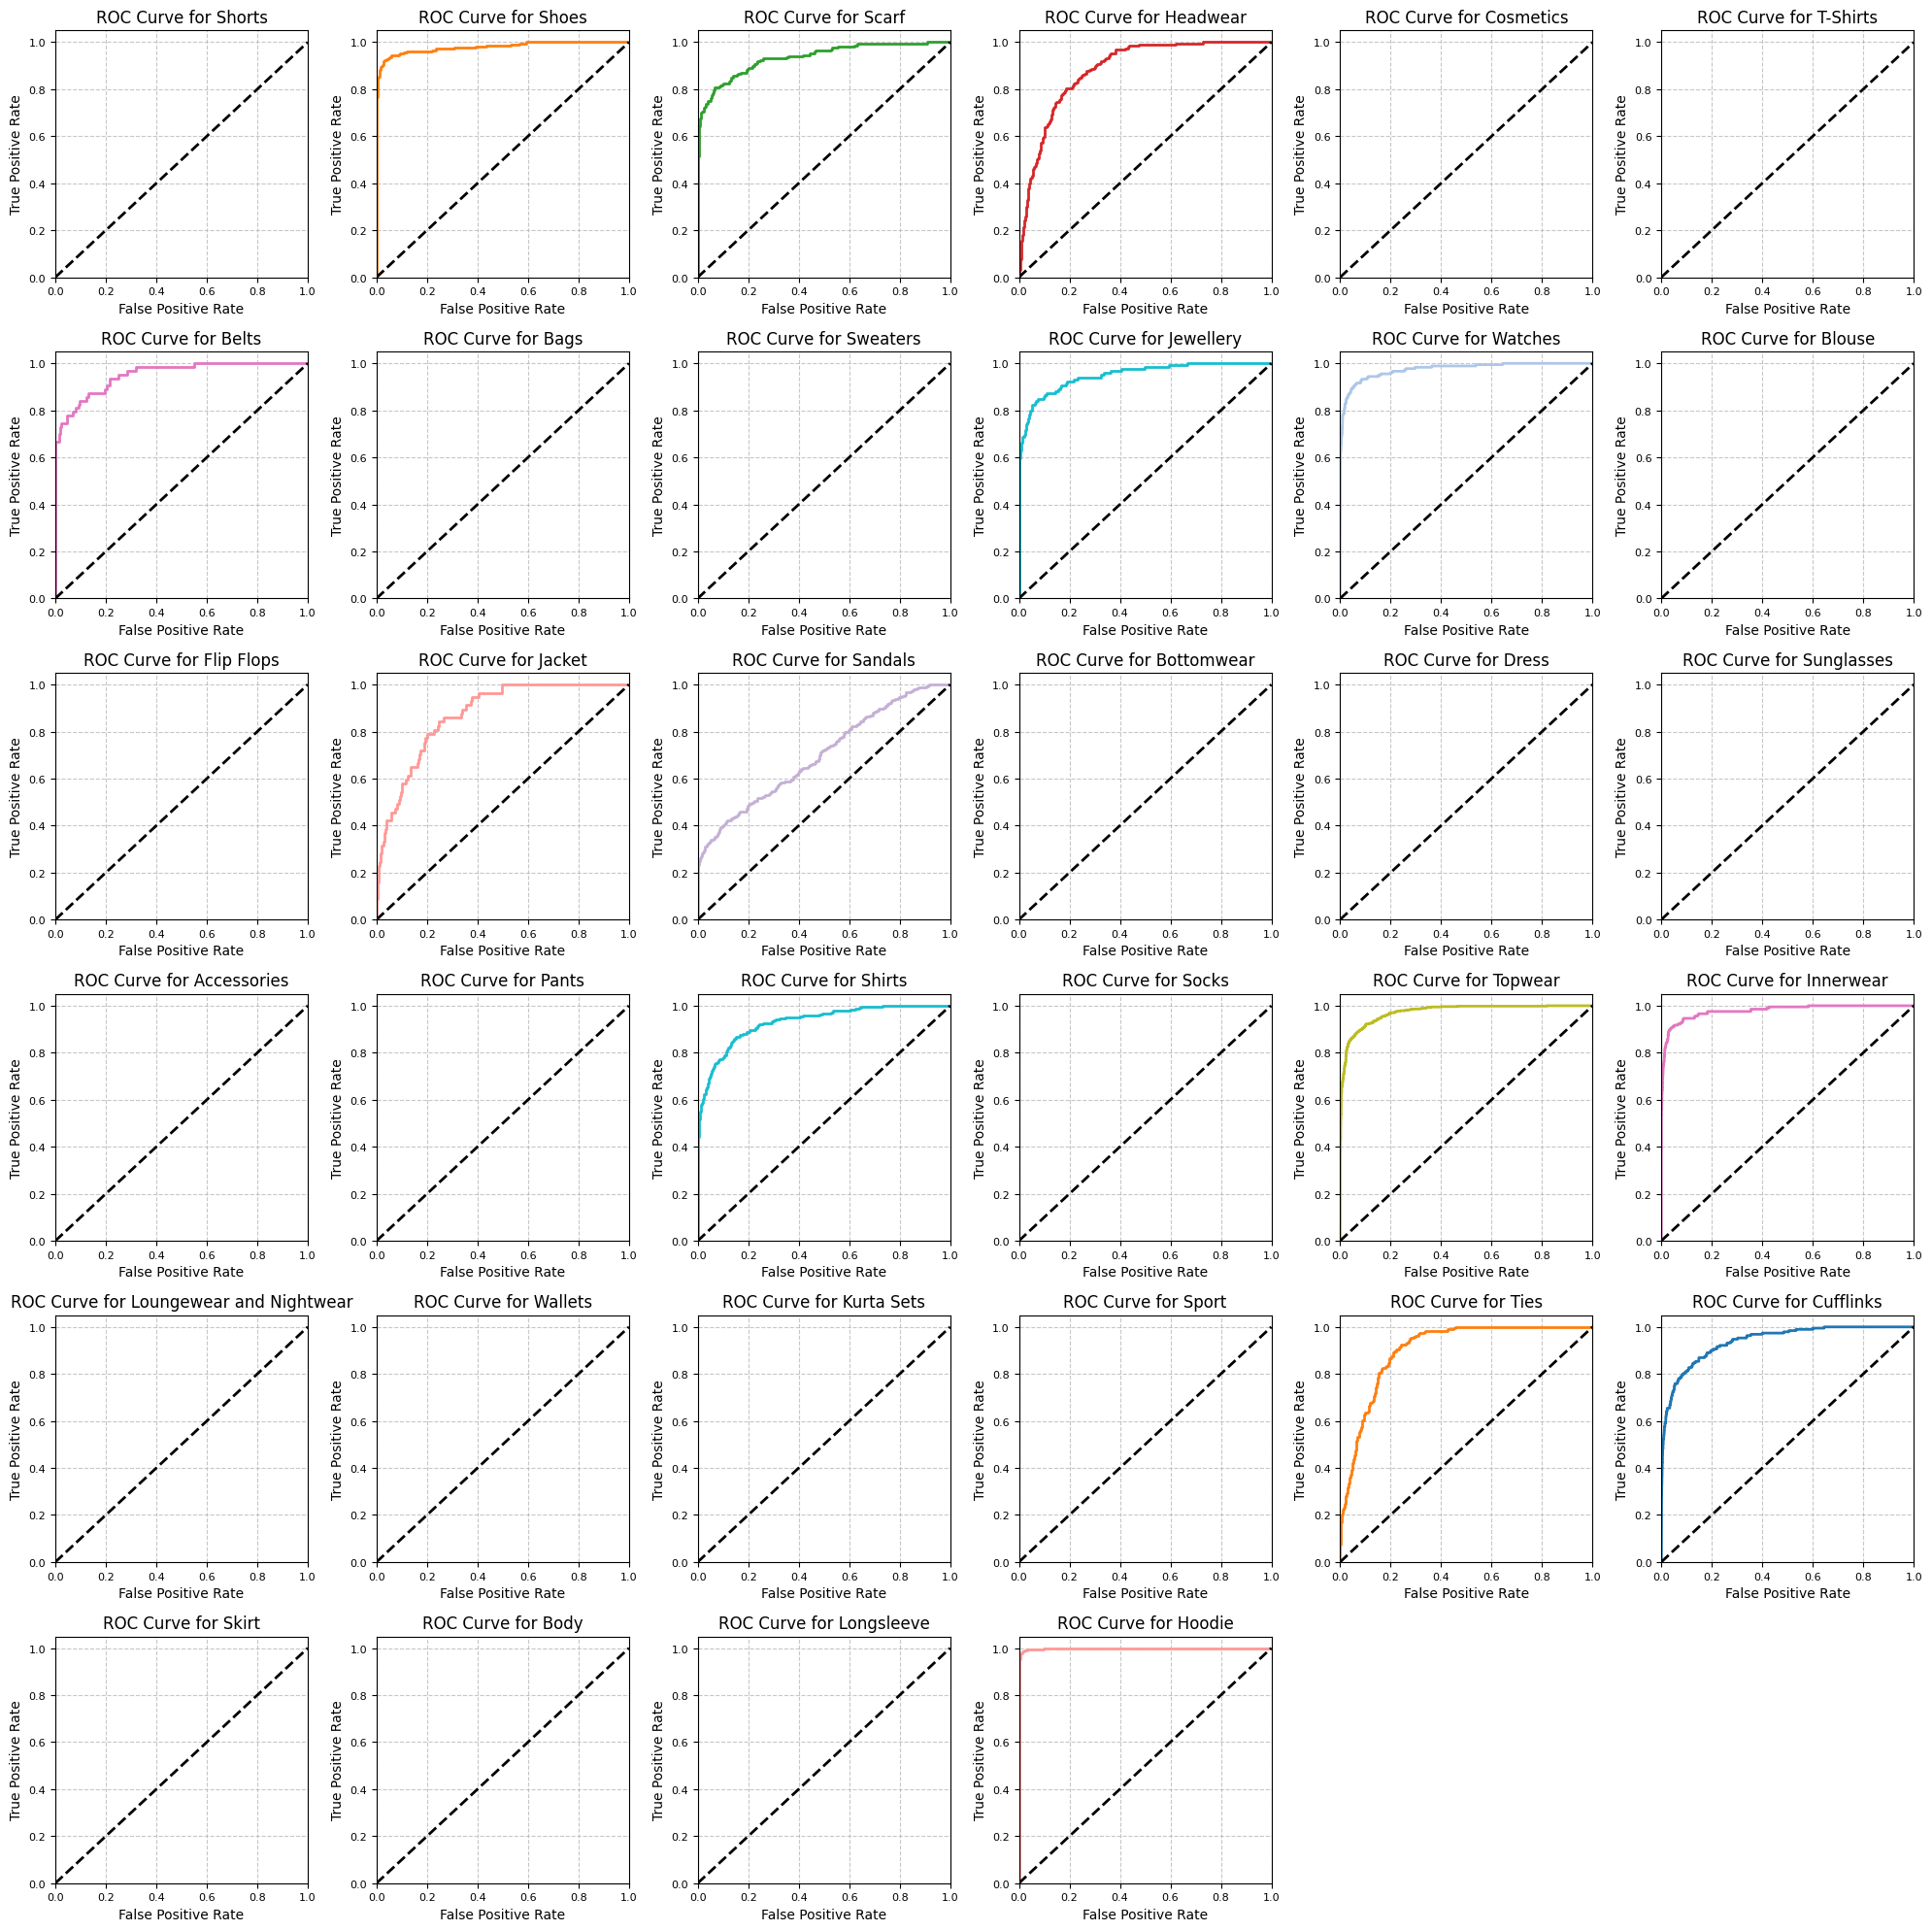

In [36]:
class_names = data['Type'].unique()

# Binarize the true labels
n_classes = Y_val.shape[1]
y_true_bin = label_binarize(y_true_classes, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Define colors for each class
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5',
          '#17becf', '#7f7f7f', '#bcbd22', '#e377c2', '#8c564b', '#9467bd', '#d62728', '#2ca02c', '#ff7f0e', '#1f77b4',
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896']

# Plot ROC curves for each class
plt.figure(figsize=(20, 20))  # Adjust figure size as needed
for i, color in zip(range(n_classes), colors):
    plt.subplot(6, 6, i+1)  # 6x6 grid of subplots
    plt.plot(fpr[i], tpr[i], color=color, lw=2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('ROC Curve for {}'.format(class_names[i]), fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.show()

## Model Testing

Now prediction is carried out on the test set

In [37]:
# Load the saved model
loaded_model = load_model("Model-Resizing.keras")

In [38]:
# Make predictions using the loaded model
predictions = loaded_model.predict(X_test_images)

# Convert predicted probabilities to most likely class labels for each sample
predicted_classes = predictions.argmax(axis=-1)

1806/1806 ━━━━━━━━━━━━━━━━━━━━ 285s 158ms/step


### Visualization of Model Predictions

Visualizing random test images along with their predicted and actual labels.

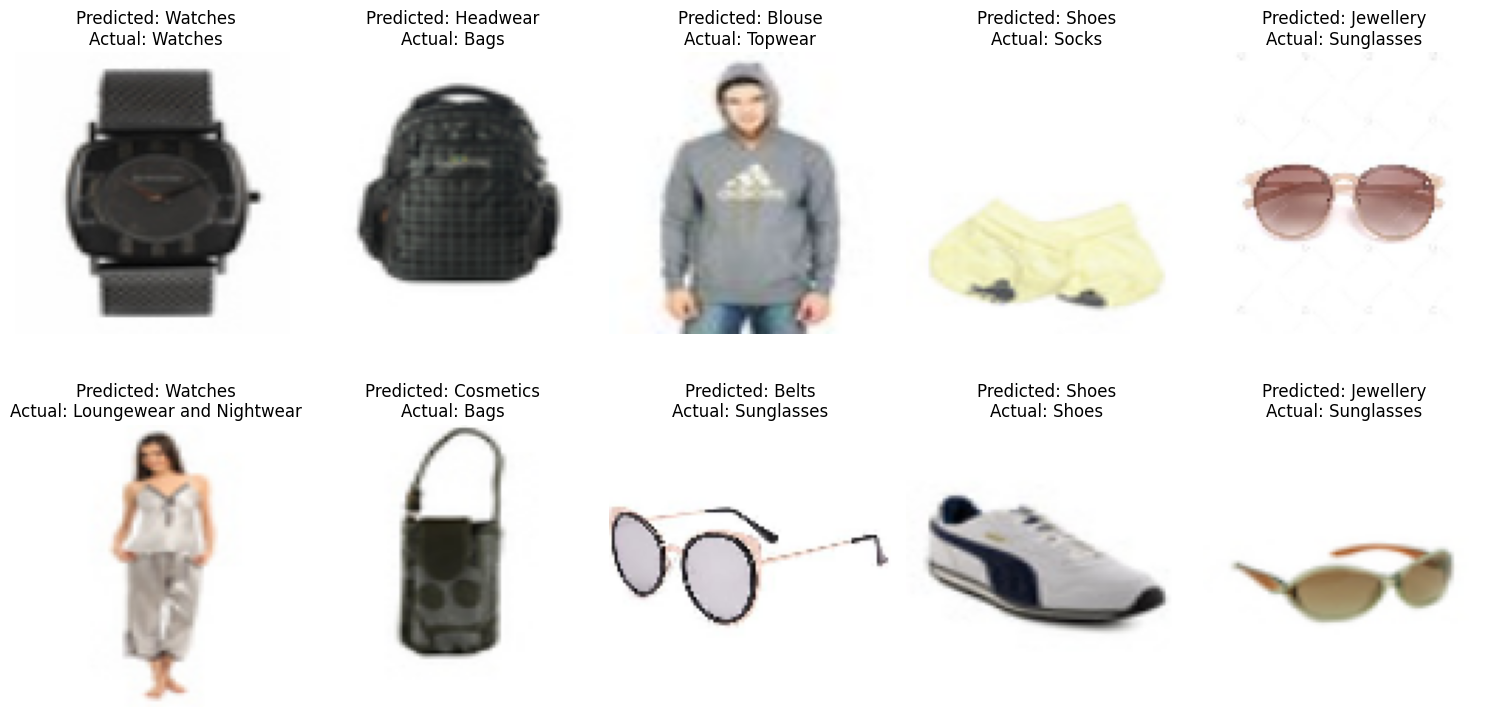

In [39]:
# Inverse transform function for the label encoder
def inverse_transform_labels(labels, encoder):
    return encoder.inverse_transform(labels)

# Plot some random images along with their predicted and actual labels
num_images_to_plot = 10
random_indices = np.random.choice(len(X_test_images), num_images_to_plot)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test_images[idx])
    predicted_label = np.argmax(predictions[idx])
    actual_label = np.argmax(Y_test[idx])
    
    # Inverse transform the numerical labels to original categorical labels
    predicted_type = inverse_transform_labels(np.array([predicted_label]), encoder)[0]
    actual_type = inverse_transform_labels(np.array([actual_label]), encoder)[0]
    
    plt.title(f"Predicted: {predicted_type}\nActual: {actual_type}")
    plt.axis('off')

plt.tight_layout()
plt.show()